# Анализ популярных кавказских песен (топ Яндекс.Музыка) с помощью Spotify

Яндекс.Музыка распределяет треки по жанрам.

Жанр "Кавказская музыка" состоит из ~500 треков.

Кавказская музыка имеет специфические особенности (некоторые треки становятся удивительно популярными за пределами Кавказа притом, что этническая составляющая в них преобладает над музыкальными тенденциями).

Интересно посмотреть, есть ли зависимость между популярностью трека и его музыкальными параметрами.

Мы возьмем метаданные этих треков (числовые показатели, которые измеряют танцевальность песен, настроение, живость и т.д.) из Spotify и проанализируем, влияют ли они на количество прослушиваний трека (которое также предоставляется Spotify).

[Подробнее о метаданных.](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)

Импортируем необходимые модули и сгенерируем таблицу для анализа.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

%matplotlib inline

df = pd.read_csv('caucasus_music.csv')
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_name,artist_name,release_date,release_date_num,track_popularity,album_name,artist_id,total_tracks,track_number,tracks_external_id
0,0.90,0.61,8.0,-9.50,0.0,0.10,0.16,0.05,0.10,0.84,...,Дико дикая,ЭGO,2019-11-29,43798,24,Дико дикая,6z0RqMOlBhJ1zgjcN5bw6d,1,1,FRX201934616
1,0.75,0.72,2.0,-6.69,1.0,0.04,0.37,0.02,0.23,0.59,...,неволновайся,Салам,2019-11-28,43797,6,неволновайся,5Exan8U6vUA0AGDvVavzsD,1,1,FRX201946473
2,0.86,0.59,10.0,-6.26,0.0,0.04,0.08,0.00,0.11,0.47,...,Хайям,Tural Everest,2019-11-26,43795,16,Хайям,1GAgS4w3PCCjbA6JKEmlLc,1,1,FRX201929596
3,0.69,0.97,0.0,-3.44,0.0,0.25,0.23,0.00,0.07,0.75,...,Царица ночи,Шамиль Кашешов,2019-11-22,43791,5,Царица ночи,5Cf8wc0BieFpCUdrY1eHrE,1,1,FRX201926928
4,0.43,0.81,10.0,-3.01,0.0,0.06,0.33,0.00,0.07,0.96,...,Дели,Арни Пашаян,2019-11-21,43790,1,Дели,28gc6lv2h6JqzvXi4TwNYx,1,1,FRX201926929


Посмотрим на зависимость значений "настроения" от "танцевальности" песен.

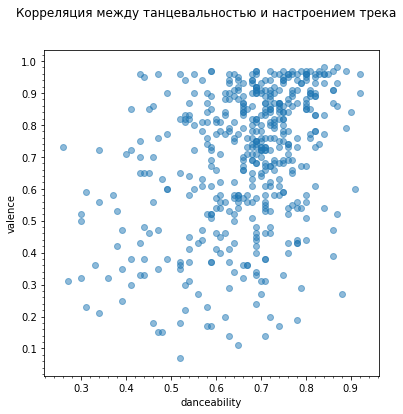

In [2]:
x = df['danceability'].values
y = df['valence'].values

x = x.reshape(x.shape[0], 1)
y = y.reshape(y.shape[0], 1)

fig = plt.figure(figsize=(6, 6))
fig.suptitle("Корреляция между танцевальностью и настроением трека")
ax = plt.subplot(1, 1, 1)
ax.scatter(x, y, alpha=0.5)
plt.xticks(())
plt.yticks(())

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.02))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

plt.xlabel('danceability')
plt.ylabel('valence')

plt.show()

Теперь создадим пару гистограмм. На графике слева показано распределение песен на основе их "энергичности", а справа - "тепловая карта", которая иллюстрирует пересечение значений "настроения" и "танцевальности".

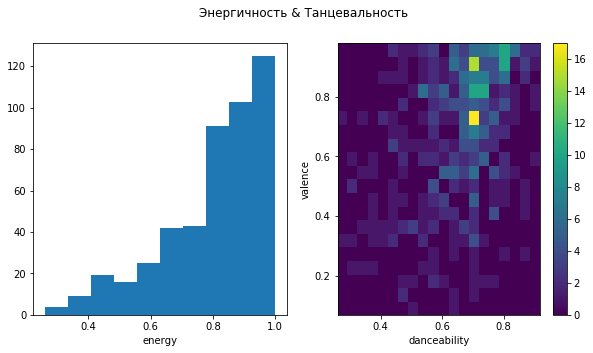

In [3]:
x = "danceability"
y = "valence"

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10, 5))
fig.suptitle("Энергичность & Танцевальность")
h = ax2.hist2d(df[x], df[y], bins=20)
ax1.hist(df["energy"])

ax2.set_xlabel(x)
ax2.set_ylabel(y)

ax1.set_xlabel("energy")

plt.colorbar(h[3], ax=ax2)

plt.show()

Создадим новый список из отобранных метаданных, которые наиболее интересны в анализе.

Далее мы используем PCA (*метод главных компонент, principal component analysis*), чтобы уменьшить размерность этого списка до 3, создавая матрицу, подходящую для генерации следующего трехмерного графика.

Чем меньше расстояние между любыми двумя песнями, тем больше сходства в их чертах.

In [4]:
!conda install plotly --yes

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

chosen = ["energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
X = df[chosen].values
y = df["danceability"].values

text = df['artist_name'] + " - " + df['track_name']
text_plot = text.values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X)

X = pca.transform(X)

trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text = text_plot,
    mode="markers",
    marker=dict(
        size=8,
        color=y
    )
)

fig = go.Figure(data=[trace])
py.iplot(fig, filename="test-graph")

Solving environment: done

# All requested packages already installed.



В другой попытке мы используем список с меньшим количеством метаданных и PCA для создания двумерного графика.

In [5]:
chosen2 = ['energy', 'liveness', 'tempo', 'valence']

X = df[chosen2].values
y = df['track_popularity'].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X)

X = pca.transform(X)

fig = {
    "data": [
        {
            "x": X[:, 0],
            "y": X[:, 1],
            "text": text_plot,
            "mode": "markers",
            "marker": {"size": 8, "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "Насколько эта песня подходит для танца?"},
        "yaxis": {"title": "Как часто слушают эту песню?"}
    }
}

py.iplot(fig, filename="test-graph2")

И, наконец, создадим график, используя список отобранных значений и t-SNE (стохастическое вложение соседей с t-распределением).

In [6]:
import time

chosen = ["energy", "liveness", "tempo", "valence", "loudness",
          "speechiness", "acousticness", "danceability", "instrumentalness"]

X = df[chosen].values
y = df["track_popularity"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 477 samples in 0.003s...
[t-SNE] Computed neighbors for 477 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 477 / 477
[t-SNE] Mean sigma: 0.203367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.231453
[t-SNE] KL divergence after 300 iterations: 0.926925
t-SNE done! Time elapsed: 1.5636286735534668 seconds


In [7]:
fig = {
    "data": [
        {
            "x": tsne_results[:, 0],
            "y": tsne_results[:, 1],
            "text": text_plot,
            "mode": "markers",
            "marker": {"size": 8, "color": y}
        }
    ],
    "layout": {
        "xaxis": {"title": "x-tsne"},
        "yaxis": {"title": "y-tsne"}
    }
}

py.iplot(fig, filename="test-graph2")